<a href="https://colab.research.google.com/github/akshayrana30/mila-courses/blob/master/knn_caravan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classification [KNN and Logistic Regression]


This notebook looks at classification with the caravan insurance data. It's
the python equivalent of section `4.6.6` in ISLR. A reminder about the data --
it describes the demographic characteristics of 5822 people, to see whether they
will buy an insurance policy. These people are measured along 85 predictors. A
full description of the dataset is
[here](http://liacs.leidenuniv.nl/~puttenpwhvander/library/cc2000/data.html) (be
forewarned, some of the column descriptions a little strange...).

First, let's look at how many people actually buy a policy.

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

caravan = pd.read_csv("https://gist.githubusercontent.com/krisrs1128/6aff9485a56fb4b26bb6271f7fd70a53/raw/de9f7cbc642871bcac7c055224ea12161982b523/caravan.csv")
n = len(caravan)
caravan["Purchase"].value_counts() / n

No     0.940227
Yes    0.059773
Name: Purchase, dtype: float64

So, not too many. We'll need to keep this baseline rate in mind when evaluating model performance (it's possible to get 94% accuracy by predicting that no one will buy insurance). Before trying to fit a KNN, let's look at the predictors.

In [0]:
caravan.describe()


,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
count,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,...,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000
mean,24.253349,1.110615,2.678805,2.991240,5.773617,0.696496,4.626932,1.069907,3.258502,6.183442,...,0.076606,0.005325,0.006527,0.004638,0.570079,0.000515,0.006012,0.031776,0.007901,0.014256
std,12.846706,0.405842,0.789835,0.814589,2.856760,1.003234,1.715843,1.017503,1.597647,1.909482,...,0.377569,0.072782,0.080532,0.077403,0.562058,0.022696,0.081632,0.210986,0.090463,0.119996
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,1.000000,2.000000,2.000000,3.000000,0.000000,4.000000,0.000000,2.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30.000000,1.000000,3.000000,3.000000,7.000000,0.000000,5.000000,1.000000,3.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,35.000000,1.000000,3.000000,3.000000,8.000000,1.000000,6.000000,2.000000,4.000000,7.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,41.000000,10.000000,5.000000,6.000000,10.000000,9.000000,9.000000,5.000000,9.000000,9.000000,...,8.000000,1.000000,1.000000,2.000000,7.000000,1.000000,2.000000,3.000000,2.000000,2.000000


In [0]:
caravan.std().sort_values()

AZEILPL      0.022696
PZEILPL      0.043462
AVRAAUT      0.062819
APERSONG     0.072782
AWAOREG      0.077403
              ...    
MOSHOOFD     2.856760
PPERSAUT     2.920669
MHHUUR       3.089302
MHKOOP       3.089837
MOSTYPE     12.846706
Length: 85, dtype: float64

It can be more informative to make histograms as well.

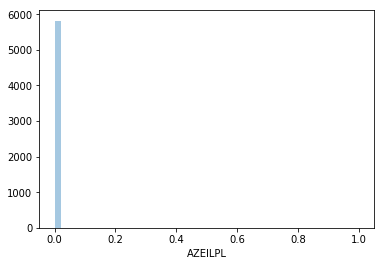

In [0]:
sns.distplot(caravan["AZEILPL"], kde=False) # income class

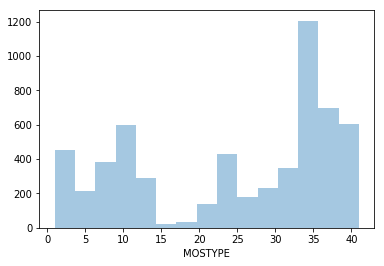

In [0]:
sns.distplot(caravan["MOSTYPE"], kde=False) # number of car policies.


We notice an immediate problem: the columns aren't all on the same scale. The
distance between samples will be very sensitive to the scales at which variables
were measured. Variables with very large ranges will artificially have more
influence in the determination of whether to samples are close to each other.
For this reason, it makes sense to normalize the columns.


In [0]:
from sklearn import preprocessing

x = caravan.iloc[:, :-1]
y = caravan["Purchase"].map(lambda z: 1 if z == "Yes" else 0)
x = (x - x.mean()) / x.std()


If we look at the variables again, they're now all on about the same scale.

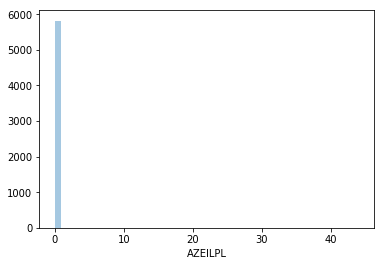

In [0]:
sns.distplot(x["AZEILPL"], kde=False) # income class


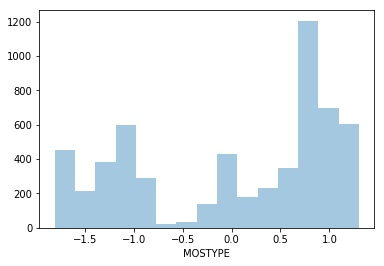

In [0]:
sns.distplot(x["MOSTYPE"], kde=False)


In [0]:
x.std()


MOSTYPE     1.0
MAANTHUI    1.0
MGEMOMV     1.0
MGEMLEEF    1.0
MOSHOOFD    1.0
           ... 
AZEILPL     1.0
APLEZIER    1.0
AFIETS      1.0
AINBOED     1.0
ABYSTAND    1.0
Length: 85, dtype: float64

Now, let's fit a KNN classifier. We'll hold out a test set, so we can honestly
evaluate performance. It seems that the precision is a bit larger than the 6\%
baseline we'd expect by random guessing. Though, run the cell a few times to
observe the variability in the test error: our guess of the generalization
performance is itself subject to estimation error. We'll revisit this idea next
week.

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

x_train, x_test, y_train, y_test= train_test_split(x, y, test_size=0.3)
model = KNeighborsClassifier(n_neighbors=1)
model.fit(x_train, y_train)
y_hat = model.predict(x_test)
errors = pd.crosstab(y_hat, y_test)
print(errors)
errors.iloc[1, 1] / np.sum(y_hat)


Purchase     0   1
row_0             
0         1556  95
1           88   8


0.08333333333333333

### Logistic Regression

Let's apply logistic regression to the same dataset. The predicted probabilities
here are going to be more informative than those in KNN (which would always be
multiples of $\frac{1}{K}$), so it's worth looking at them, in addition to the error rates.

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


([array([42., 31., 19.,  9.,  1.,  0.,  0.,  0.,  0.,  1.]),
  array([1.252e+03, 2.700e+02, 7.700e+01, 2.500e+01, 9.000e+00, 6.000e+00,
         0.000e+00, 1.000e+00, 2.000e+00, 2.000e+00])],
 array([9.11216965e-06, 7.19768209e-02, 1.43944530e-01, 2.15912238e-01,
        2.87879947e-01, 3.59847656e-01, 4.31815365e-01, 5.03783074e-01,
        5.75750782e-01, 6.47718491e-01, 7.19686200e-01]),
 <a list of 2 Lists of Patches objects>)

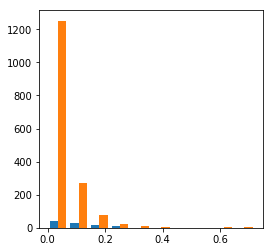

In [0]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(x_train, y_train)

p_hat = model.predict_proba(x_test)[:, 1]
preds = pd.DataFrame(
  np.stack([
    p_hat,
    p_hat > 0.25,
    y_test
  ], axis=1)
)
preds.columns = ["p1", "y_hat", "y"]
preds = preds.reset_index()

fig, ax = plt.subplots(figsize=(4,4))
ax.hist([preds.loc[preds["y"] == 1, "p1"],preds.loc[preds["y"] == 0, "p1"]])


The fact that the relative decay of the blue bars (true purchasers) is more
gradual than that for the orange bars (nonpurchasers) is a good sign. We can
also make a table of errors, like before. The performance seems noticeably
better.

A useful exercise is to change the probability cutoff used to declare someone a
purchaser or a nonpurchaser, and see how the precision (the error rate we're
plotting) changes as a consequence.

In [0]:
errors = pd.crosstab(preds["y_hat"], preds["y"])
print(errors)
errors.iloc[1, 1] / np.sum(preds["y_hat"])


y       0.0  1.0
y_hat           
0.0    1615   95
1.0      29    8


0.21621621621621623

One added bonus of logistic regression is that we can easily inspect how the
variables influence the predicted probability. An increase in one unit in
variable $\beta_j$ multiplies the predicted probability by $e^{\beta_j}$, (this
quantity is called the relative risk). Let's look at some of the relative risks.

If you look up the meanings of the variables, it seems like having some sort of
insurance through another group makes you less likely to purchase insurance,
which makes sense.

Challenge: Some of these variables don't actually make sense as ordered
categories (I'm surprised that ISLR completely glosses over this fact). Which
ones, and what would you do about it?

In [0]:
beta = pd.DataFrame(np.stack([x.columns, model.coef_[0]], axis=1))
beta.columns = ["variable", "estimate"]
beta["rel_risk"] = beta["estimate"].map(np.exp)
beta.sort_values("rel_risk")

,variable,estimate,rel_risk
17,MOPLLAAG,-0.63739,0.528670
64,AWAPART,-0.454486,0.634774
74,ABROM,-0.419523,0.657360
62,PINBOED,-0.325707,0.722017
35,MZPART,-0.312181,0.731849
...,...,...,...
57,PWAOREG,0.356859,1.428835
58,PBRAND,0.481345,1.618250
43,PWAPART,0.499782,1.648362
27,MSKC,0.518229,1.679051
